# Minimum Snap Trajectory
## Model
* control input $\mathbf u = [u_1, u_2, u_3, u_4]^T$
	* $u_1$ net body force
	* $u_2, u_3, u_4$ body moments according to rotor speeds
* state $\mathbf x = [x, y, z, \phi, \theta, \psi, \dot{x}, \dot{y}, \dot{z}, p, q, r]^T$

## Differential Flatness
* flat outputs $\sigma = [x, y, z , \psi]^T$
	* coordinates of COM $\mathbf r = [x, y, z]^T$
	* yaw angle $\psi$


## Trajectory Optimization
Quadratic Program (QP):
$$
\min\int_{t_o}^{t_m}
\mu_r \left|\left|\frac{d^{k_r}\mathbf{r}_{\text{T}}}{dt^{k_r}}\right|\right| +
\mu_\psi \left|\left|\frac{d^{k_\psi}\psi_{\text{T}}}{dt^{k_\psi}}\right|\right|
dt
$$
s.t.
$$
\begin{aligned}
\sigma_T(t_i)&=\sigma_i ,&\qquad j = 0, \dots, m \\
\left.\frac{d^Px_T}{dt^P}\right|_{t=t_j} &= 0 \text{ or free,} &\qquad  j = 0, \dots, m; p=1, \dots, k_r \\
\left.\frac{d^Py_T}{dt^P}\right|_{t=t_j} &= 0 \text{ or free,} &\qquad  j = 0, \dots, m; p=1, \dots, k_r \\
\left.\frac{d^Pz_T}{dt^P}\right|_{t=t_j} &= 0 \text{ or free,} &\qquad  j = 0, \dots, m; p=1, \dots, k_r \\
\left.\frac{d^P\psi_T}{dt^P}\right|_{t=t_j} &= 0 \text{ or free,} &\qquad  j = 0, \dots, m; p=1, \dots, k_\psi
\end{aligned}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys, rospy, rosbag, glob, re, math

import scipy
import scipy.stats
from scipy.stats import pearsonr

from smap.msg import smapStats

from IPython.display import HTML, display

from matplotlib.path import Path
import matplotlib.patches as patches
from matplotlib import cm
from numpy import linspace
from matplotlib.colors import LogNorm
from decimal import *

def deg2rad(deg):
    return deg / 180. * np.pi

keyframes = [
    [0, 0, deg2rad(0)],
    [2, 0, deg2rad(90)],
    [2, 6, deg2rad(180)],
    [0, 6, deg2rad(0)]
]
times = [0, 0.3, 0.7, 1.0]

## Nondimensionalization
Quantities $x_t, y_T, z_T, \psi_T$ are decoupled in cost function and constraints of the QP.
Hence, they can be separated into 4 optimization problems. Considering a general form for a nondimensional variable $\tilde{w}(\tau)$ where $\tau$ represents nondimensionalized time:
$$
\begin{aligned}
\min &\int_0^1 \frac{d^k\tilde{w}(\tau)^2}{d\tau^k}d\tau&\\
\text{s.t.} &\qquad \tilde{w}(\tau_i) = \tilde{w}_i, &\qquad i=0,\dots,m\\
&\qquad \left.\frac{d^P\tilde{w}(\tau)}{d\tilde{w}^P}\right|_{\tau=\tau_j}=0\text{ or free}, &\qquad t_j=0,\dots,1; p=1,\dots,k
\end{aligned}
$$

In [2]:
k = 3 # dimensions
d = 5 # polynomial degree

C = [
    [0, 0, 1],
    [1, 0, 0]
]

times = np.linspace(0, 1, 100)

def polynomial(times, constraints, continuity=2, degree=4):
    pass

### Evaluation for a single, piecewise polynomial

In [3]:
x_s = [0, 0]
x_f = [3, 6]
degree = 2
dimensions = 2
times = np.linspace(0, 1, 100)

C = x_s + x_f
np.linalg.pinv

def time_matrix(t, rows, cols):    
    return np.poly1d([t] * cols)

The $(d+1)\times (c+1)$ time matrix is computed for a specific time $t$ and stores in each column the monomials of the $c_i$-th derivative ($c_i\in[0,c]$) of a $d$ degree polynomial which are evaluated at time $t$.

For example, for degree $d=5$ and continuity $c=3$, we get the following time matrix at time $t=2$:
$$
\begin{pmatrix}
t^5 & 5t^4 & 20t^3 & 60t^2 \\
t^4 & 4t^3 & 12t^2 & 24t   \\
t^3 & 3t^2 & 6t    & 6     \\
t^2 & 2t   & 2     & 0     \\
t^1 & 1    & 0     & 0     \\
t^0 & 0    & 0     & 0 
\end{pmatrix}
=\begin{pmatrix}
32 & 80 & 160 & 240 \\
16 & 32 & 48  & 48  \\
8  & 12 & 12  & 6     \\
4  & 4  & 2   & 0     \\
2  & 1  & 0   & 0     \\
1  & 0  & 0   & 0 
\end{pmatrix}
$$

In [4]:
def time_matrix(time, degree, continuity):
    time_matrix = np.zeros((degree+1, continuity+1))

    poly = np.poly1d([1] * (degree+1))
    for derivation in range(continuity+1):
        time_matrix[:int(len(poly)+1), derivation] = [c*time**d for c, d in zip(poly, range(len(poly),-1,-1))]
        # print "p%s(%i) = %s\n%s" % ("'" * derivation, t, str([c*t**d for c, d in zip(poly, range(len(poly),-1,-1))] + [0]*(continuity-len(poly)-1)), poly)
        poly = np.polyder(poly)

    return time_matrix

Given start and end constraints $\mathbf x_s, \mathbf x_f$, the following method computes the space of polynomials that satisfy these constraints.

Continuity is the number of derivatives that shall be computed per polynomial (one polynomial for each time step).

In [5]:
import scipy
import numpy as np
from scipy import linalg, matrix
# computes the null space of a matrix A
def null_space(A, eps=1e-12):
    u, s, vh = scipy.linalg.svd(A)
    padding = max(0,np.shape(A)[1]-np.shape(s)[0])
    null_mask = np.concatenate(((s <= eps), np.ones((padding,),dtype=bool)),axis=0)
    null_space = scipy.compress(null_mask, vh, axis=0)
    return scipy.transpose(null_space)

In [6]:
def piecewise_min_snap(x_s, x_f, times, degree=4):
    dimensions = x_s.shape[0]
    cperdim = x_s.shape[1]
    continuity = cperdim # or number of columns in a constraint
    
    dd = degree + 1
    cc = continuity + 1

    n_columns = (len(times)-2) * cc + cperdim + cperdim
    n_rows = (len(times)-1) * dd

    print "Columns:", n_columns
    print "Rows:", n_rows
    print "Dimensions:", dimensions
    # knot_intervals = np.diff(times)
    # time_scale = 1 / np.max(knot_intervals)
    # times *= time_scale

    constraints = np.zeros((dimensions, n_columns))
    constraints[:, :cperdim] = x_s
    constraints[:, -cperdim:] = x_f
    print "Constraints:", constraints.shape
    # print constraints

    zero_time_matrix = -time_matrix(0, degree, continuity)
    # print "Zero Time Matrix:\n", zero_time_matrix

    polynomials = np.zeros((n_rows, n_columns))
    print "Polynomials:", polynomials.shape
    polynomials[:dd, :cperdim] = time_matrix(times[0], degree, cperdim-1)
    for i in range(2, len(times)):
        col = (i-2) * cc + cperdim
        row = (i-2) * dd
        polynomials[row:row+dd, col:col+cc] = \
            time_matrix(times[i]-times[i-1], degree, continuity)
        polynomials[row+dd:row+2*dd, col:col+cc] = zero_time_matrix

    polynomials[-dd:, -cperdim:] = \
        time_matrix(times[-1]-times[-2], degree, cperdim-1)

    # print (polynomials[:13, :13])
    # print (polynomials[-13:, -13:])
    solution = (constraints.dot(np.linalg.pinv(polynomials)))
    free = null_space(polynomials.T)
    print "Solution:", solution.shape
    print "Null space:", free.shape

    return solution, free

x_s = np.array([[2, 0, 0], [9, 0, 0]])
x_f = np.array([[5, 0, 0], [2, 0, 0]])
degree = 4
times = np.linspace(0, 1, 6)
solution, free = piecewise_min_snap(x_s, x_f, times, degree)

Columns: 22
Rows: 25
Dimensions: 2
Constraints: (2, 22)
Polynomials: (25, 22)
Solution: (2, 25)
Null space: (25, 3)


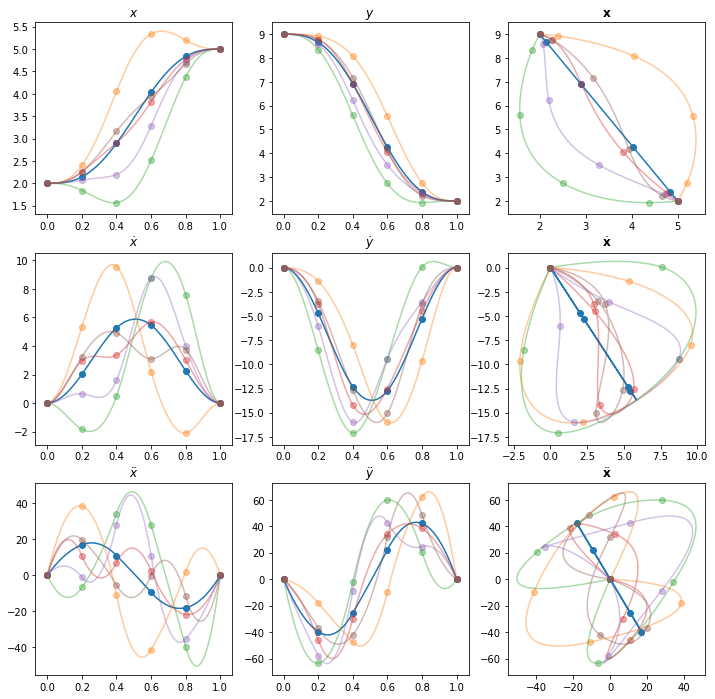

In [7]:
%matplotlib inline
def trajectory_curve(sol, intermediary=20):
    curve = []
    ts = []
    dots = []
    for i, (t1, t2) in enumerate(zip(times, times[1:])):
        poly = np.poly1d((sol[i, :]))
        if i == 0:
            curve.append(np.polyval(poly, 0))
            ts.append(0)
        step = (t2-t1) / intermediary
        dots.append(np.polyval(poly, 0))
        for j in range(1, intermediary+1):
            curve.append(np.polyval(poly, j*step))
            ts.append(t1 + j*step)
        if i == len(times)-2:
            dots.append(np.polyval(poly, t2-t1))
    return ts, curve, dots

def trajectory_dots(sol):
    dots = []
    for i, (t1, t2) in enumerate(zip(times, times[1:])):
        dots.append(np.polyval(poly, 0))
        if i == len(times)-2:
            dots.append(np.polyval(poly, t2-t1))
    return dots

def trajectory_curve_derivation(sol, der=1, intermediary=20):
    curve = []
    ts = []
    dots = []
    for i, (t1, t2) in enumerate(zip(times, times[1:])):
        poly = np.poly1d((sol[i, :]))
        poly = np.polyder(poly, m=der)
        if i == 0:
            curve.append(np.polyval(poly, 0))
            ts.append(0)
        step = (t2-t1) / intermediary
        dots.append(np.polyval(poly, 0))
        for j in range(1, intermediary+1):
            curve.append(np.polyval(poly, j*step))
            ts.append(t1 + j*step)
        if i == len(times)-2:
            dots.append(np.polyval(poly, t2-t1))
    return ts, curve, dots

def trajectory_dots_derivation(sol, der=1, intermediary=20):
    dots = []
    for i, (t1, t2) in enumerate(zip(times, times[1:])):
        poly = np.poly1d((sol[i, :]))
        poly = np.polyder(poly, m=der)
        dots.append(np.polyval(poly, 0))
        if i == len(times)-2:
            dots.append(np.polyval(poly, t2-t1))
    return dots

dd = degree + 1
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(12, 12))
ax1.set_title("$x$")
ax2.set_title("$y$")
ax3.set_title("$\\bf x$")
ts, xs, xdots = trajectory_curve(solution[0,:].reshape((-1, dd)))
ax1.plot(ts, xs)
ax1.scatter(times, xdots)
_, ys, ydots = trajectory_curve(solution[1,:].reshape((-1, dd)))
ax2.plot(ts, ys)
ax2.scatter(times, ydots)
ax3.plot(xs, ys)
ax3.scatter(xdots, ydots)
rs = []
for k in range(5):
    r = 500 * (np.random.rand(free.shape[1], 1) - 0.5)
    rs.append(r)
    sol = solution + free.dot(r).T
    _, xs, xdots = trajectory_curve(sol[0,:].reshape((-1, dd)))
    ax1.plot(ts, xs, alpha=0.4)
    ax1.scatter(times, xdots, alpha=0.4)
    _, ys, ydots = trajectory_curve(sol[1,:].reshape((-1, dd)))
    ax2.plot(ts, ys, alpha=0.4)
    ax2.scatter(times, ydots, alpha=0.4)
    ax3.plot(xs, ys, alpha=0.4)
    ax3.scatter(xdots, ydots, alpha=0.4)
    
ax4.set_title("$\\dot{x}$")
ax5.set_title("$\\dot{y}$")
ax6.set_title("$\\dot{\\bf x}$")
ts, xs, xdots = trajectory_curve_derivation(solution[0,:].reshape((-1, dd)))
ax4.plot(ts, xs)
ax4.scatter(times, xdots)
_, ys, ydots = trajectory_curve_derivation(solution[1,:].reshape((-1, dd)))
ax5.plot(ts, ys)
ax5.scatter(times, ydots)
ax6.plot(xs, ys)
ax6.scatter(xdots, ydots)
for r in rs:
    sol = solution + free.dot(r).T
    _, xs, xdots = trajectory_curve_derivation(sol[0,:].reshape((-1, dd)))
    ax4.plot(ts, xs, alpha=0.4)
    ax4.scatter(times, xdots, alpha=0.4)
    _, ys, ydots = trajectory_curve_derivation(sol[1,:].reshape((-1, dd)))
    ax5.plot(ts, ys, alpha=0.4)
    ax5.scatter(times, ydots, alpha=0.4)
    ax6.plot(xs, ys, alpha=0.4)
    ax6.scatter(xdots, ydots, alpha=0.4)
    
ax7.set_title("$\\ddot{x}$")
ax8.set_title("$\\ddot{y}$")
ax9.set_title("$\\ddot{\\bf x}$")
ts, xs, xdots = trajectory_curve_derivation(solution[0,:].reshape((-1, dd)), der=2)
ax7.plot(ts, xs)
ax7.scatter(times, xdots)
_, ys, ydots = trajectory_curve_derivation(solution[1,:].reshape((-1, dd)), der=2)
ax8.plot(ts, ys)
ax8.scatter(times, ydots)
ax9.plot(xs, ys)
ax9.scatter(xdots, ydots)
for r in rs:
    sol = solution + free.dot(r).T
    _, xs, xdots = trajectory_curve_derivation(sol[0,:].reshape((-1, dd)), der=2)
    ax7.plot(ts, xs, alpha=0.4)
    ax7.scatter(times, xdots, alpha=0.4)
    _, ys, ydots = trajectory_curve_derivation(sol[1,:].reshape((-1, dd)), der=2)
    ax8.plot(ts, ys, alpha=0.4)
    ax8.scatter(times, ydots, alpha=0.4)
    ax9.plot(xs, ys, alpha=0.4)
    ax9.scatter(xdots, ydots, alpha=0.4)

In [68]:
# generate 2d toy map
voxel_size = 0.1
xmin, xmax = -1, 1
ymin, ymax = -1, 1

obstacle1 = [
    (-1, -1),  # left bottom
    (-.1, -.3) # right top
]

obstacle2 = [
    (-1, .3), # left bottom
    (-.1, 1)  # right top
]

smoothness = 1.9 * voxel_size
certainty = 0.7
prior = 0.5

def generate_voxel_patch(x, y, mean=None, color=None, size=voxel_size):
    return patches.Rectangle(
        xy=(x, y),
        width=size,
        height=size,
        color="black" if color is None else color,
        alpha=1 if mean is None else mean)

def bernoulli_std(p):
    return np.sqrt(p * (1-p))

def distance_point_rect(p, rect_center, rect_dim):
    dx = max(abs(p[0] - rect_center[0]) - rect_dim[0] / 2, 0)
    dy = max(abs(p[1] - rect_center[1]) - rect_dim[1] / 2, 0)
    return np.sqrt(dx ** 2 + dy ** 2)

def estimate_map(x, y):
    if ((obstacle1[0][0] <= x <= obstacle1[1][0]) and (obstacle1[0][1] <= y <= obstacle1[1][1])) or \
        ((obstacle2[0][0] <= x <= obstacle2[1][0]) and (obstacle2[0][1] <= y <= obstacle2[1][1])):
            # obstacle
            mean = prior + certainty * (1 - prior)
#             print mean
            return mean, bernoulli_std(mean)
    else:
        obstacle1_center = np.mean([obstacle1[0], obstacle1[1]], axis=0)
        obstacle1_dim = np.abs(np.array(obstacle1[1]) - np.array(obstacle1[0]))
#         print obstacle1_center
#         print obstacle1_dim
        dist1 = distance_point_rect((x, y), obstacle1_center, obstacle1_dim)
        obstacle2_center = np.mean([obstacle2[0], obstacle2[1]], axis=0)
        obstacle2_dim = np.abs(np.array(obstacle2[1]) - np.array(obstacle2[0]))
        dist2 = distance_point_rect((x, y), obstacle2_center, obstacle2_dim)
#         print dist1 + dist2
        n = prior
        m = -n / smoothness
        truth = max(m * (min(dist1, dist2) - smoothness) + n, 0)
#         print dist1 + dist2, truth
        mean = (truth - prior) * certainty + prior
#         print mean
        return mean, bernoulli_std(mean)

xdim = int((xmax-xmin) / voxel_size + 1)
ydim = int((ymax-ymin) / voxel_size + 1)
world = [[() for i in range(xdim)] for j in range(ydim)]
for i in range(xdim):
    x = xmin + i * voxel_size
    for j in range(ydim):
        y = ymin + j * voxel_size
        world[i][j] = estimate_map(x, y)

def plot_world(ax):
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    ax.set_xticks(np.arange(xmin, xmax, voxel_size))
    ax.set_yticks(np.arange(ymin, ymax, voxel_size))
    ax.grid()

    for i in range(xdim):
        x = xmin + i * voxel_size
        for j in range(ydim):
            y = ymin + j * voxel_size
            ax.add_patch(generate_voxel_patch(x, y, world[i][j][0]))      

Columns: 22
Rows: 25
Dimensions: 2
Constraints: (2, 22)
Polynomials: (25, 22)
Solution: (2, 25)
Null space: (25, 3)
Best UCB: 0.0404002488619
Optimization terminated successfully.
         Current function value: -0.052334
         Iterations: 25
         Function evaluations: 106
  status: 0
    nfev: 106
 success: True
     fun: -0.052334401527076482
       x: array([  42.83173753,  -29.7521324 ,  133.12869533])
 message: 'Optimization terminated successfully.'
     nit: 25


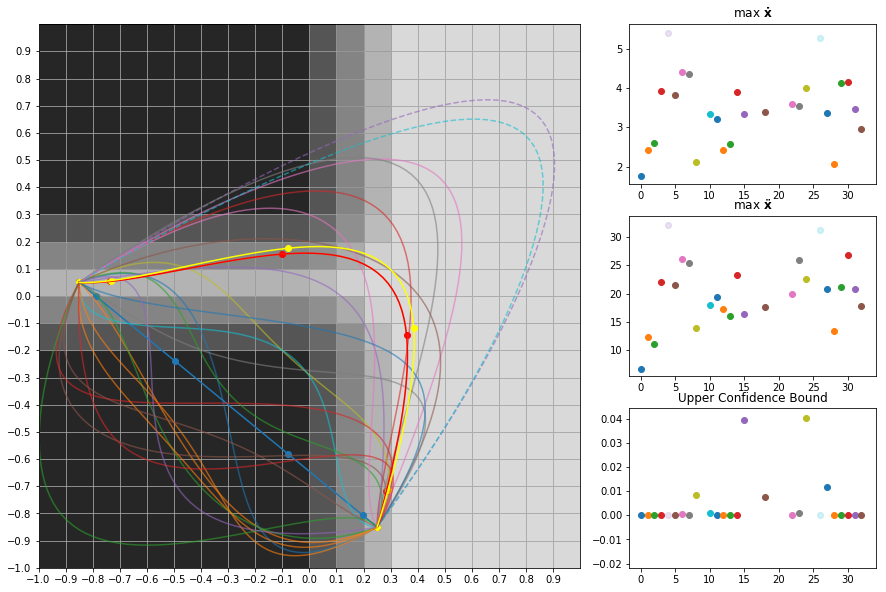

In [44]:
fig = plt.figure(figsize=(15,10))
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(3, 3)
ax = fig.add_subplot(gs[:3, :2])

ax2 = fig.add_subplot(gs[0, 2])
ax2.set_title("$\\max\ \\bf \\dot{x}$")
ax3 = fig.add_subplot(gs[1, 2])
ax3.set_title("$\\max\ \\bf \\ddot{x}$")
ax4 = fig.add_subplot(gs[2, 2])
ax4.set_title("Upper Confidence Bound")

plot_world(ax)

x_s = np.array([[ 0.25, 0, 0], [-0.85, 0, 0]])
x_f = np.array([[-0.85, 0, 0], [ 0.05, 0, 0]])
degree = 4
times = np.linspace(0, 1, 6)

solution, free = piecewise_min_snap(x_s, x_f, times, degree)
ts, xs, xdots = trajectory_curve(solution[0,:].reshape((-1, dd)))
_, ys, ydots = trajectory_curve(solution[1,:].reshape((-1, dd)))
ax.plot(xs, ys)
ax.scatter(xdots, ydots, zorder=2)

_, xs, _ = trajectory_curve_derivation(solution[0,:].reshape((-1, dd)))
_, ys, _ = trajectory_curve_derivation(solution[1,:].reshape((-1, dd)))
ax2.scatter([0], [max(np.max(xs), np.max(ys))])
_, xs, _ = trajectory_curve_derivation(solution[0,:].reshape((-1, dd)), der=2)
_, ys, _ = trajectory_curve_derivation(solution[1,:].reshape((-1, dd)), der=2)
ax3.scatter([0], [max(np.max(xs), np.max(ys))])

def evaluate(solution, kappa=-3.2): # todo kappa is NEGATIVE!!
    _, xs, _ = trajectory_curve(solution[0,:].reshape((-1, dd)))
    _, ys, _ = trajectory_curve(solution[1,:].reshape((-1, dd)))

    # draw occupied voxels
    occupied = set()
    for x, y in zip(xs, ys):
        i = int((x - xmin) / voxel_size)
        j = int((y - ymin) / voxel_size)
        if i < 0 or j < 0 or i >= xdim or j >= ydim:
            return -1000
        occupied.add((i, j))
    
    reach_left, reach_right = Decimal(1), Decimal(1)
    reach = 1.
    for (i, j) in occupied:
#         x = xmin + i * voxel_size
#         y = ymin + j * voxel_size
#         ax.add_patch(generate_voxel_patch(x, y, 0.5, color="orange"))
        
        mean, std = world[i][j]
        var = Decimal(std) ** Decimal(2)
        mean_sq = Decimal(1.-mean) ** Decimal(2)
        reach_left *= var + mean_sq
        reach_right *= mean_sq        
        reach *= 1. - mean
        
    var_reachability = reach_left - reach_right    
    KAPPA = Decimal(kappa)
    ucb = float(Decimal(reach) - var_reachability.sqrt() * KAPPA)
    return ucb
    
ax4.scatter([0], evaluate(solution))

MAX_VELOCITY = 5
MAX_ACCELERATION = 30

best_ucb = (evaluate(solution), xs, ys, 100 * (np.random.rand(free.shape[1], 1) - 0.5), xdots, ydots)
for k in range(35):
    r = 300 * (np.random.rand(free.shape[1], 1) - 0.5)
    sol = solution + free.dot(r).T
    _, xs, xdots = trajectory_curve(sol[0,:].reshape((-1, dd)))
    _, ys, ydots = trajectory_curve(sol[1,:].reshape((-1, dd)))
    xs, ys = np.array(xs), np.array(ys)
    if any(xs < xmin) or any(ys < ymin) or any(xs > xmax) or any(ys > ymax):
        continue
    ucb = evaluate(sol)
    
    _, xds, _ = trajectory_curve_derivation(sol[0,:].reshape((-1, dd)))
    _, yds, _ = trajectory_curve_derivation(sol[1,:].reshape((-1, dd)))
    max_velocity = max(np.max(np.abs(xds)), np.max(np.abs(yds)))
    _, xdds, _ = trajectory_curve_derivation(sol[0,:].reshape((-1, dd)), der=2)
    _, ydds, _ = trajectory_curve_derivation(sol[1,:].reshape((-1, dd)), der=2)
    max_acceleration = max(np.max(np.abs(xdds)), np.max(np.abs(ydds)))
    
    out_of_bounds = max_velocity > MAX_VELOCITY or max_acceleration > MAX_ACCELERATION
    
    ax2.scatter([k+1], [max_velocity], alpha=0.2 if out_of_bounds else 1)
    ax3.scatter([k+1], [max_acceleration], alpha=0.2 if out_of_bounds else 1)
    
    if ucb > -1000:
        ax4.scatter([k+1], ucb, alpha=0.2 if out_of_bounds else 1)
    else:
        ax4.scatter([k+1], np.nan)
    if not out_of_bounds and ucb > best_ucb[0]:
        best_ucb = (ucb, xs, ys, r, xdots, ydots)
    ax.plot(xs, ys, alpha=0.6, linestyle="dashed" if out_of_bounds else "solid")

print "Best UCB:", best_ucb[0]
ax.plot(best_ucb[1], best_ucb[2], color="red")
ax.scatter(best_ucb[4], best_ucb[5], color="red", zorder=2)

r = best_ucb[3]
def best_ucb(params):
    sol = solution + free.dot(np.array(params)).T
    ucb = evaluate(sol)
    return -ucb  # maximize, i.e. minimize negative UCB


from scipy.optimize import minimize

# res = minimize(best_ucb, r, method='Powell', options={'xtol': 1e-15, 'ftol': 1e-15, 'disp': True, 'maxiter': 2000, 'maxfev': 2000})
res = minimize(best_ucb, r, method='Nelder-Mead', options={'xtol': 1e-5, 'disp': True, 'maxiter': 100})
# minimizer_kwargs = {"method": "Powell"}
# res = scipy.optimize.basinhopping(best_ucb, r, minimizer_kwargs=minimizer_kwargs, niter=100)

print res
r = np.array(res.x)
sol = solution + free.dot(r).T
_, xs, xdots = trajectory_curve(sol[0,:].reshape((-1, dd)))
_, ys, ydots = trajectory_curve(sol[1,:].reshape((-1, dd)))
ax.plot(xs, ys, color="yellow")
ax.scatter(xdots, ydots, color="yellow", zorder=2)

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


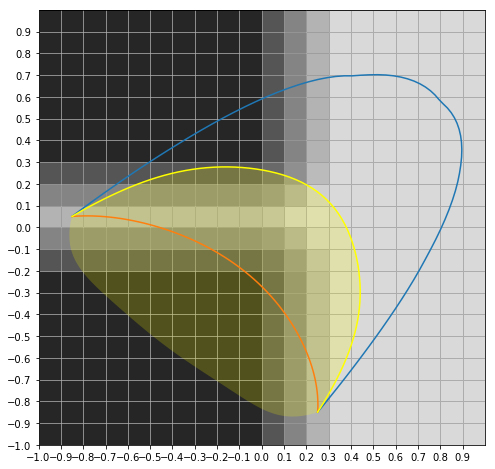

In [38]:
from tqdm import tnrange, tqdm_notebook
from ipywidgets import FloatProgress
from IPython.display import display

fig, ((ax)) = plt.subplots(1, 1, figsize=(8, 8))
plot_world(ax)

choices = 20
per_dimension = np.linspace(-200, 300, choices)
full_choice = np.tile(per_dimension, (free.shape[1], 1))

valid_xs = []
valid_ys = []
iterations = int(choices ** free.shape[1])
f = FloatProgress(min=0, max=iterations)
display(f)
#for i in tnrange(iterations):
for i in range(iterations):
    param = []
    index = i
    for d in range(free.shape[1]-1, -1, -1):
        j = int(index / (choices ** d))
        index = index % (choices ** d)
        param.append(per_dimension[j])
#     print i, param
    
    sol = solution + free.dot(np.array(param)).T
    
    _, xs, _ = trajectory_curve(sol[0,:].reshape((-1, dd)))
    _, ys, _ = trajectory_curve(sol[1,:].reshape((-1, dd)))
    xs, ys = np.array(xs), np.array(ys)
    if any(xs < xmin) or any(ys < ymin) or any(xs > xmax) or any(ys > ymax):
        continue
    
    _, xds, _ = trajectory_curve_derivation(sol[0,:].reshape((-1, dd)))
    _, yds, _ = trajectory_curve_derivation(sol[1,:].reshape((-1, dd)))
    max_velocity = max(np.max(np.abs(xds)), np.max(np.abs(yds)))
    _, xdds, _ = trajectory_curve_derivation(sol[0,:].reshape((-1, dd)), der=2)
    _, ydds, _ = trajectory_curve_derivation(sol[1,:].reshape((-1, dd)), der=2)
    max_acceleration = max(np.max(np.abs(xdds)), np.max(np.abs(ydds)))
    
    out_of_bounds = max_velocity > MAX_VELOCITY or max_acceleration > MAX_ACCELERATION
    
    if not out_of_bounds:
        _, xs, _ = trajectory_curve(sol[0,:].reshape((-1, dd)))
        _, ys, _ = trajectory_curve(sol[1,:].reshape((-1, dd)))
#         ax.plot(xs, ys, alpha=0.3)
        valid_xs.append(xs)
        valid_ys.append(ys)
    
    if i % 100 == 0:
        f.value = i
    
valid_xs = np.array(valid_xs)
valid_ys = np.array(valid_ys)
# ax.fill_between(np.mean(valid_xs, axis=0), np.mean(valid_ys, axis=0) - np.std(valid_ys, axis=0), np.mean(valid_ys, axis=0) + np.std(valid_ys, axis=0), facecolor='yellow', alpha=0.2, edgecolor='none', antialiased=True, zorder=2)
mx, my = np.mean(valid_xs, axis=0), np.mean(valid_ys, axis=0)
sx, sy = np.std(valid_xs, axis=0), np.std(valid_ys, axis=0)
ax.fill(np.concatenate([np.flip(mx - sx, 0), mx + sx]), np.concatenate([np.flip(my - sy, 0), my + sy]), facecolor='yellow', alpha=0.2, edgecolor='none', antialiased=True, zorder=2)
ax.plot(np.max(valid_xs, axis=0), np.max(valid_ys, axis=0), label="max", zorder=2)
ax.plot(np.mean(valid_xs, axis=0), np.mean(valid_ys, axis=0), label="$\\mu$", zorder=2)
ax.plot(np.mean(valid_xs, axis=0) + np.std(valid_xs, axis=0), np.mean(valid_ys, axis=0) + np.std(valid_ys, axis=0), color="yellow", label="$\\mu+\\sigma$", zorder=2)

  status: 2
    nfev: 352
 success: False
     fun: -3.2681536424711184e-13
       x: array([ -98.43540371,  108.58220876,   81.3637322 ])
 message: 'Maximum number of iterations has been exceeded.'
     nit: 200


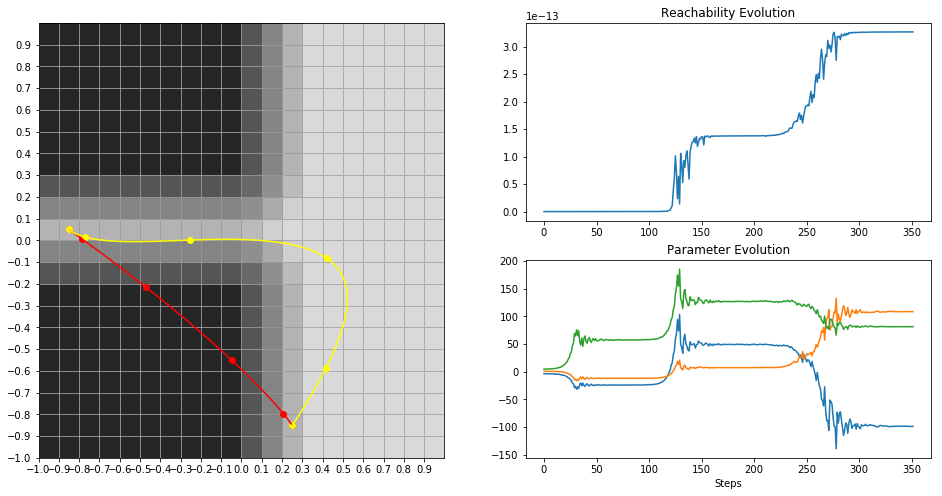

In [66]:
fig = plt.figure(figsize=(16,8))
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2, 2)
ax = fig.add_subplot(gs[:2, :1])

ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Reachability Evolution")
ax3 = fig.add_subplot(gs[1, 1])
ax3.set_title("Parameter Evolution")
ax3.set_xlabel("Steps")

plot_world(ax)

param = 10 * (np.random.rand(free.shape[1], 1) - 0.5)
sol = solution + free.dot(param).T
_, xs, xdots = trajectory_curve(sol[0,:].reshape((-1, dd)))
_, ys, ydots = trajectory_curve(sol[1,:].reshape((-1, dd)))
ax.plot(xs, ys, color="red")
ax.scatter(xdots, ydots, color="red", zorder=2)

param_evolution = []
reach_evolution = []

def reachability(solution):
    global reach_evolution
    
    _, xs, _ = trajectory_curve(solution[0,:].reshape((-1, dd)))
    _, ys, _ = trajectory_curve(solution[1,:].reshape((-1, dd)))

    occupied = set()
    for x, y in zip(xs, ys):
        i = int((x - xmin) / voxel_size)
        j = int((y - ymin) / voxel_size)
        if i < 0 or j < 0 or i >= xdim or j >= ydim:
            return -1000
        occupied.add((i, j))
    
    reach = 1.
    for (i, j) in occupied:        
        mean, std = world[i][j]     
        reach *= 1. - mean
        
    reach_evolution.append(reach)
    return reach

def smooth_reachability(solution):
    global reach_evolution
    
    _, xs, _ = trajectory_curve(solution[0,:].reshape((-1, dd)))
    _, ys, _ = trajectory_curve(solution[1,:].reshape((-1, dd)))

    reach = 1.
    for x, y in zip(xs, ys):       
        mean, std = estimate_map(x, y)    
        reach *= 1. - mean
        
    reach_evolution.append(reach)
    return reach

def best_reachability(param):
    global param_evolution
    param_evolution.append(param)
    sol = solution + free.dot(np.array(param)).T
    return -smooth_reachability(sol)

res = minimize(best_reachability, param, method='Nelder-Mead', options={'xtol': 1e-15, 'disp': True, 'maxiter': 200})
# minimizer_kwargs = {"method": "Powell"}
# res = scipy.optimize.basinhopping(best_reachability, param, minimizer_kwargs=minimizer_kwargs, niter=100, stepsize=10)

ax2.plot(reach_evolution)
param_evolution = np.array(param_evolution)
for d in range(free.shape[1]):
    ax3.plot(param_evolution[:, d])
    
print res
r = np.array(res.x)
sol = solution + free.dot(r).T
_, xs, xdots = trajectory_curve(sol[0,:].reshape((-1, dd)))
_, ys, ydots = trajectory_curve(sol[1,:].reshape((-1, dd)))
ax.plot(xs, ys, color="yellow")
ax.scatter(xdots, ydots, color="yellow", zorder=2)

As can be seen, the optimization performance (e.g. using Nelder-Mead) improves significantly, when a continuous map representation is used, since the cost function is not discrete anymore due to changes in voxel occupancy by the trajectory.
Basin Hopping with a larger step size (10) was able to generate good results, even on the discrete map representation. However, this seems to be that way mostly due to the random displacement of the parameters. If the step size of this displacement is not that large anymore, Basin Hopping also fails to escape the grid constraints.

In the real mapping setting, we cannot rely on a smooth mapping function but have to deal with the voxel grid for optimization. In order to still get a smooth sampling of real coordinates in the voxel grid, bilinear filtering can be used as it is a common computer graphics technique to sample from 2d textures.

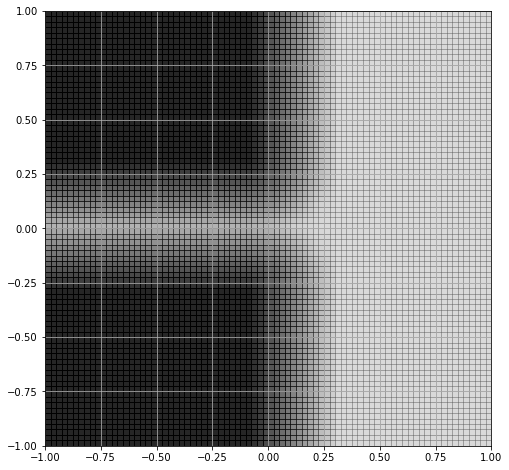

In [82]:
def bilinear_filter(x, y):    
    u = (x - xmin) / voxel_size
    v = (y - ymin) / voxel_size
    x = int(u)
    y = int(v)
    u_ratio = u - x
    v_ratio = v - y
    u_opposite = 1 - u_ratio
    v_opposite = 1 - v_ratio
    x, y = max(min(xdim - 1, x), 0), max(min(ydim - 1, y), 0)
    xp, yp = max(min(xdim - 1, x + 1), 0), max(min(ydim - 1, y + 1), 0) # repeat voxels at edges
    def filter_index(i):
        return (world[x][y][i] * u_opposite + world[xp][y][i] * u_ratio) * v_opposite \
            + (world[x][yp][i] * u_opposite  + world[xp][yp][i] * u_ratio) * v_ratio
    return filter_index(0), filter_index(1)

# plot example smoothed map with much smaller voxels
def plot_smoothed_world(ax, nvoxel_size):
    xdim = int((xmax-xmin) / nvoxel_size + 1)
    ydim = int((ymax-ymin) / nvoxel_size + 1)
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
#     ax.set_xticks(np.arange(xmin, xmax, nvoxel_size))
#     ax.set_yticks(np.arange(ymin, ymax, nvoxel_size))
    ax.grid()

    for i in range(xdim):
        x = xmin + i * nvoxel_size
        for j in range(ydim):
            y = ymin + j * nvoxel_size
            ax.add_patch(generate_voxel_patch(x, y, bilinear_filter(x, y)[0], size=nvoxel_size))

fig, ((ax)) = plt.subplots(1, 1, figsize=(8, 8))
nvoxel_size = voxel_size / 4
plot_smoothed_world(ax, nvoxel_size)

  status: 2
    nfev: 359
 success: False
     fun: -2.3531159970765052e-13
       x: array([-109.2871483 ,  117.05054279,   79.03924823])
 message: 'Maximum number of iterations has been exceeded.'
     nit: 200


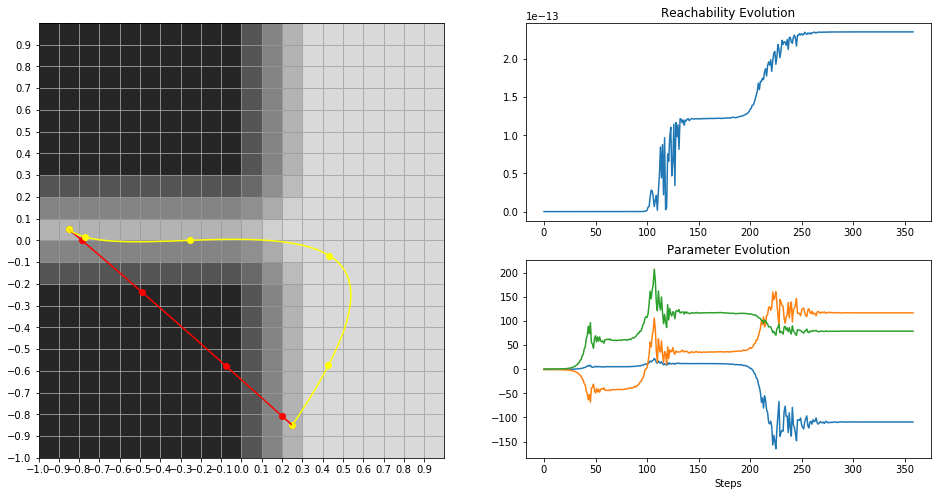

In [85]:
fig = plt.figure(figsize=(16,8))
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2, 2)
ax = fig.add_subplot(gs[:2, :1])

ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Reachability Evolution")
ax3 = fig.add_subplot(gs[1, 1])
ax3.set_title("Parameter Evolution")
ax3.set_xlabel("Steps")

plot_world(ax)

param = 10 * (np.random.rand(free.shape[1], 1) - 0.5)
sol = solution + free.dot(param).T
_, xs, xdots = trajectory_curve(sol[0,:].reshape((-1, dd)))
_, ys, ydots = trajectory_curve(sol[1,:].reshape((-1, dd)))
ax.plot(xs, ys, color="red")
ax.scatter(xdots, ydots, color="red", zorder=2)

param_evolution = []
reach_evolution = []
def bilinear_reachability(solution):
    global reach_evolution
    
    _, xs, _ = trajectory_curve(solution[0,:].reshape((-1, dd)))
    _, ys, _ = trajectory_curve(solution[1,:].reshape((-1, dd)))

    reach = 1.
    for x, y in zip(xs, ys):
#         u = (x - xmin) / voxel_size
#         v = (y - ymin) / voxel_size
#         x = int(u)
#         y = int(v)
#         mean, std = world[x][y]
        mean, std = bilinear_filter(x, y)
        reach *= 1. - mean
        
    reach_evolution.append(reach)
    return reach

def best_reachability(param):
    global param_evolution
    param_evolution.append(param)
    sol = solution + free.dot(np.array(param)).T
    return -bilinear_reachability(sol)

res = minimize(best_reachability, param, method='Nelder-Mead', options={'xtol': 1e-25, 'disp': True, 'maxiter': 200})
# minimizer_kwargs = {"method": "Powell"}
# res = scipy.optimize.basinhopping(best_reachability, param, minimizer_kwargs=minimizer_kwargs, niter=10, stepsize=10)

ax2.plot(reach_evolution)
param_evolution = np.array(param_evolution)
for d in range(free.shape[1]):
    ax3.plot(param_evolution[:, d])
    
print res
r = np.array(res.x)
sol = solution + free.dot(r).T
_, xs, xdots = trajectory_curve(sol[0,:].reshape((-1, dd)))
_, ys, ydots = trajectory_curve(sol[1,:].reshape((-1, dd)))
ax.plot(xs, ys, color="yellow")
ax.scatter(xdots, ydots, color="yellow", zorder=2)